## Importing Libraries

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

## Loading data

In [0]:
#Olivetti Faces
h_image,w_image=64,64
data=fetch_olivetti_faces()
images = data.images.reshape((data.images.shape[0],\
                                data.images.shape[1], data.images.shape[2]))
labels=(data.target)
X_train, X_test, y_train, y_test = train_test_split(images,
                                                  labels, test_size=0.01)



## Data Generator

In [0]:
epochs=50
batch_size=50

train_dataset=tf.data.Dataset.from_tensor_slices((X_train,X_train)).\
batch(batch_size).repeat()

test_dataset=tf.data.Dataset.from_tensor_slices((X_test,X_test)).\
batch(batch_size).repeat()

## Model 

In [73]:
def conv_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2D(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  
def conv_transpose_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2DTranspose(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  

def model(input_shape,latent_dim):
  #Encoder 
  model_input=tf.keras.Input(input_shape)
  layer=conv_layer(model_input,16,5,strides=2)
  layer=conv_layer(layer,32,3,strides=2)
  layer=conv_layer(layer,64,3,strides=2)
  layer=conv_layer(layer,128,3,strides=2)
  shape_before_flatten=layer.shape
  layer=tf.keras.layers.Flatten()(layer)
  mean=tf.keras.layers.Dense(latent_dim)(layer)
  var=tf.keras.layers.Dense(latent_dim)(layer)
  encoder_model=tf.keras.models.Model(model_input,[mean,var])
  
  #Decoder
  decoder_input=tf.keras.Input((latent_dim,))
  layer=tf.keras.layers.Dense(np.prod(shape_before_flatten[1:]),\
                              activation='relu')(decoder_input)
  layer=tf.keras.layers.Reshape(target_shape=shape_before_flatten[1:])(layer)
  layer=conv_transpose_layer(layer,128,3,strides=2)
  layer=conv_transpose_layer(layer,64,3,strides=2)
  layer=conv_transpose_layer(layer,32,3,strides=2)
  layer=conv_transpose_layer(layer,16,5,strides=2)
  layer=conv_transpose_layer(layer,1,3,activation='sigmoid')
  decoder_model=tf.keras.models.Model(decoder_input,layer)  
 
  #Reparameterization Trick
  mean,var=encoder_model(model_input)
  epsilon=tf.random.normal(shape=(tf.shape(var)[0],
                                  tf.shape(var)[1]))
  z=mean+tf.exp(var)*epsilon
  model_out=decoder_model(z)
  model=tf.keras.models.Model(model_input,model_out)
  model.summary()

  #KL div loss
  kl_loss= 0.5 * tf.reduce_sum(tf.square(mean) - 1 - var + tf.exp(var))
  #Reconstruction loss
  reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(model_input),
                                            tf.keras.backend.flatten(model_out))
  vae_loss = (reconstruction_loss + kl_loss)
  model.add_loss(vae_loss)

  return model,decoder_model,encoder_model

input_shape=(h_image,w_image,1)
latent_dim=2

vae_model,decoder_model,encoder_model=model(input_shape,latent_dim)


Model: "model_92"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model_90 (Model)                [(None, 2), (None, 2 105604      input_62[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Shape_90 (TensorFlo [(2,)]               0           model_90[1][1]                   
__________________________________________________________________________________________________
tf_op_layer_Shape_91 (TensorFlo [(2,)]               0           model_90[1][1]                   
___________________________________________________________________________________________

In [74]:
vae_model,decoder_model,encoder_model=model(input_shape,latent_dim)

vae_model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

callback=[(tf.keras.callbacks.ModelCheckpoint(filepath='/content/mnist_model.h5',
                                            patience=0, verbose=0))]
vae_model.fit(train_dataset,epochs=100,callbacks=callback,steps_per_epoch=(len(X_train)//batch_size))

Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model_93 (Model)                [(None, 2), (None, 2 105604      input_64[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Shape_93 (TensorFlo [(2,)]               0           model_93[1][1]                   
__________________________________________________________________________________________________
tf_op_layer_Shape_94 (TensorFlo [(2,)]               0           model_93[1][1]                   
___________________________________________________________________________________________

## Inference

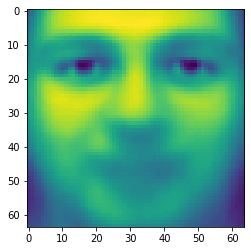

In [75]:
#Testing using decoder
test_example=tf.random.normal(shape=[num_example,latent_dim])
pred=decoder_model.predict(test_example)
plt.imshow(np.reshape(pred,(h_image,w_image)))
plt.show()
